In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind, shapiro
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scikit_posthocs import posthoc_tukey
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df_main = pd.read_csv("pagelite_main.csv", index_col=0)
df_login = pd.read_csv("pagelite_login.csv", index_col=0)
df_pricing = pd.read_csv("pagelite_pricing.csv", index_col=0)

In [4]:
def Data_Prep(dataframe, group, target):
    
    dataframe[group] = dataframe[group].apply(str)
    
    def is_outlier(s):
        Q1 = s.quantile(0.25)
        Q3 = s.quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        return ~s.between(lower_limit, upper_limit)
    
    # Remove outliers
    dataframe = dataframe[~dataframe.groupby(group)[target].apply(is_outlier)]
    dataframe.reset_index(drop=True, inplace=True)
    
    return dataframe

In [5]:
def Multivar_AB_Testing(dataframe, page_name, group, target):
    
    dataframe = Data_Prep(dataframe, group, target)
    
    # extract unique groups
    groups = []
    for g in dataframe[group].unique():
        df = dataframe[dataframe[group]==g]
        groups.append(df[target].values)
    
    # perform one-way ANONVA
    anova = stats.f_oneway(*groups)
    
    if anova[1] < 0.05: # if p<0.05, then at least one of the mean values is significantly different
        
        # perform Tukey's test
        tukey = pairwise_tukeyhsd(endog=dataframe[target],
                                  groups=dataframe[group],
                                  alpha=0.05)
        df_tukey = pd.DataFrame(data=tukey._results_table.data[1:], 
                                columns=tukey._results_table.data[0])
        
        # fetch the info about the groups and merge
        df_info = pd.read_csv("pages_info.csv", usecols=["page.version", "group.codes"])
        df_info = df_info[df_info['page.version'].str.contains(page_name.lower())]
        df_info['page.version.num'] = df_info['page.version'].str.split('.').str[1]
        df = df_tukey.merge(df_info, left_on="group1", right_on="page.version.num").merge(df_info, left_on="group2", right_on="page.version.num")
        df = df[["group1", "group.codes_x", "group2", "group.codes_y", "meandiff", "lower", "upper", "p-adj", "reject"]]
        df = df.rename({'group.codes_x': 'group1.codes', 'group.codes_y': 'group2.codes'}, axis=1)
        
    else:  # if p>0.05
        return "There is no significant difference across the means"

    return df

In [6]:
Multivar_AB_Testing(df_main, "main", "group", "clicks").head(10)

,group1,group1.codes,group2,group2.codes,meandiff,lower,upper,p-adj,reject
0,0,original,1,title on left & login button is red,-9.3231,-10.9054,-7.7408,0.0000,True
1,0,original,2,title on right & login button is red,-9.2459,-10.8681,-7.6236,0.0000,True
2,1,title on left & login button is red,2,title on right & login button is red,0.0772,-1.2367,1.3912,1.0000,False
3,0,original,3,title on left & login button is orange,-9.7365,-11.3154,-8.1576,0.0000,True
4,1,title on left & login button is red,3,title on left & login button is orange,-0.4134,-1.6734,0.8467,0.9898,False
5,2,title on right & login button is red,3,title on left & login button is orange,-0.4906,-1.8004,0.8192,0.9743,False
6,0,original,4,title on right & login button is orange,-9.2225,-10.8566,-7.5885,0.0000,True
7,1,title on left & login button is red,4,title on right & login button is orange,0.1006,-1.2280,1.4292,1.0000,False
8,2,title on right & login button is red,4,title on right & login button is orange,0.0233,-1.3526,1.3992,1.0000,False
9,3,title on left & login button is orange,4,title on right & login button is orange,0.5139,-0.8106,1.8384,0.9676,False


In [7]:
# test between two options

def AB_Testing(dataframe, page_name, group, target, A, B):
    
    # apply multiple hypotheses testing and select the results of the given pair
    df = Multivar_AB_Testing(dataframe, page_name, group, target)
    df = df.loc[(df.group1==A) & (df.group2==B)].reset_index(drop=True)
    
    return df

In [8]:
AB_Testing(df_main, "main", "group", "clicks", "0", "7")

,group1,group1.codes,group2,group2.codes,meandiff,lower,upper,p-adj,reject
0,0,original,7,pricing bolded,-9.0819,-10.6952,-7.4685,0.0,True


In [9]:
# take 2 options, return the better one and the difference

def Better_Option(dataframe, page_name, group, target, A, B):
    
    # apply multiple hypotheses testing and select the results the given pair
    df = AB_Testing(df_main, page_name, group, target, A, B)
    
    if df['reject'].iloc[0] == True:  # if there is significant difference
        
        meandiff = df['meandiff'].iloc[0]  
        
        if meandiff < 0:
            return df['group1'][0], df['group1.codes'][0], abs(meandiff)
        else:
            return df['group2'][0], df['group2.codes'][0], abs(meandiff)
        
        # returns (better_group, better_group_code, effect)
        
    else:
        return "No Significant Difference"

In [10]:
Better_Option(df_main, "main", "group", "clicks", "0", "7")

('0', 'original', 9.0819)

In [11]:
# return the page version with the best result of the given variable

def Best_Option(dataframe, page_name, group, target):
    
    df1 = Multivar_AB_Testing(dataframe, page_name, group, target)
    
    df2 = df1.loc[(df1.reject==True)]  # select the pairs with significant difference
    df2 = df2.loc[df2.meandiff==df2.meandiff.max()]  # select the pair with max difference
    df2 = df2.reset_index(drop=True)
    
    if df2['meandiff'].iloc[0] < 0:
        return df2['group1'][0], df2['group1.codes'][0]
    else:
        return df2['group2'][0], df2['group2.codes'][0]
    
    # returns (best_group, best_group_code)

In [12]:
Best_Option(df_main, "main", "group", "clicks")

('0', 'original')

In [13]:
Best_Option(df_login, "login", "group", "lifetime")

('1', 'text fields bolded')

In [14]:
def Comparison_Plot1(dataframe, page_name, group, target):
    
    dataframe = Data_Prep(dataframe, group, target)
    
    # perform Tukey's test
    tukey = pairwise_tukeyhsd(endog=dataframe[target],
                              groups=dataframe[group],
                              alpha=0.05)
    # return plot
    return tukey.plot_simultaneous()

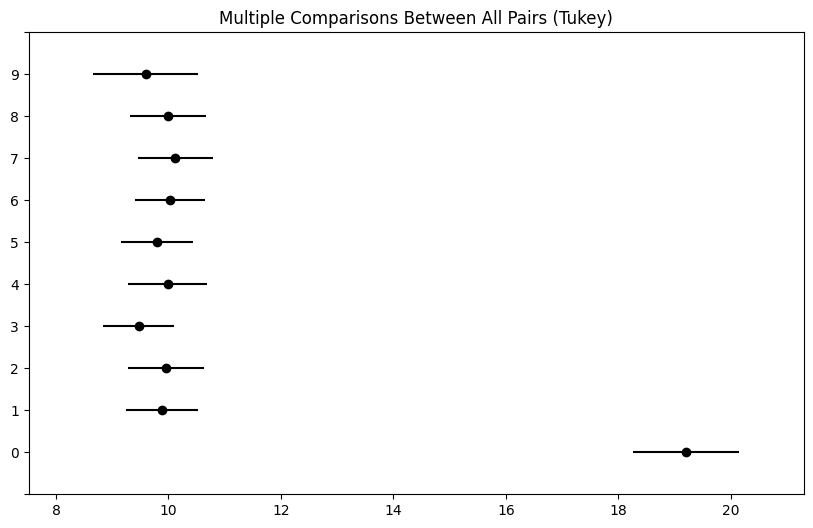

In [15]:
Comparison_Plot1(df_main, "main", "group", "clicks")

**Interpretation:** The plot shows the means (black dots) and the 95% confidence intervals (the horizontal lines) for each group. In the case above, the mean of clicks for Group 0 is significantly greater than that for all others, but among the Groups 1,2,...,9 there is no significant difference, since their confidence intervals overlap.

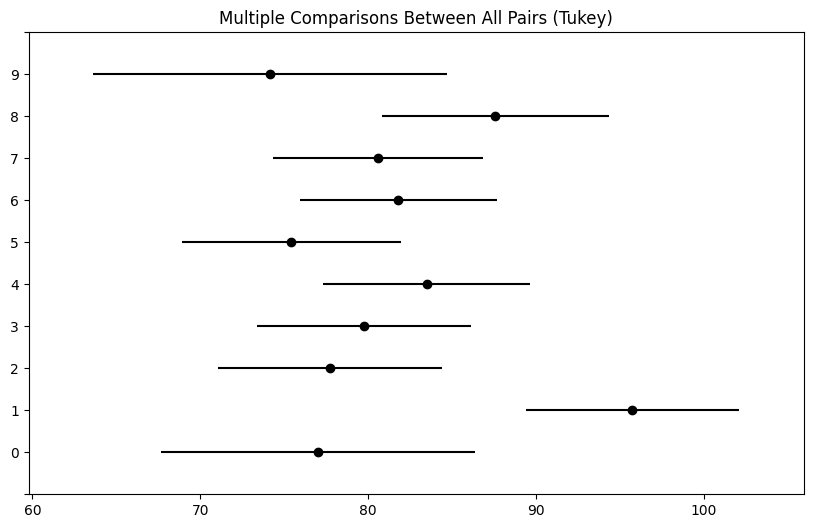

In [16]:
Comparison_Plot1(df_login, "login", "group", "lifetime")

In [17]:
def Comparison_Plot2(dataframe, page_name, group, target):
    
    dataframe = Data_Prep(dataframe, group, target)
    
    tukey_df = posthoc_tukey(dataframe, val_col=target, 
                             group_col=group).sort_index().sort_index(axis=1)
    remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
    tukey_df[remove] = np.nan
    molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
    molten_df = molten_df.loc[molten_df.value < 0.05]
    
    ax = sns.boxplot(data=dataframe, x=group, y=target);
    pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()];
    p_values = [i[1]["value"] for i in molten_df.iterrows()];
    annotator = Annotator(ax, pairs, data=dataframe, x=group, y=target);
    annotator.configure(text_format="star", loc="inside");
    annotator.set_pvalues_and_annotate(p_values);

    return ax

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

5 vs. 0: Custom statistical test, P_val:1.000e-03
8 vs. 0: Custom statistical test, P_val:1.000e-03
4 vs. 0: Custom statistical test, P_val:1.000e-03
1 vs. 0: Custom statistical test, P_val:1.000e-03
7 vs. 0: Custom statistical test, P_val:1.000e-03
9 vs. 0: Custom statistical test, P_val:1.000e-03
2 vs. 0: Custom statistical test, P_val:1.000e-03
6 vs. 0: Custom statistical test, P_val:1.000e-03
3 vs. 0: Custom statistical test, P_val:1.000e-03


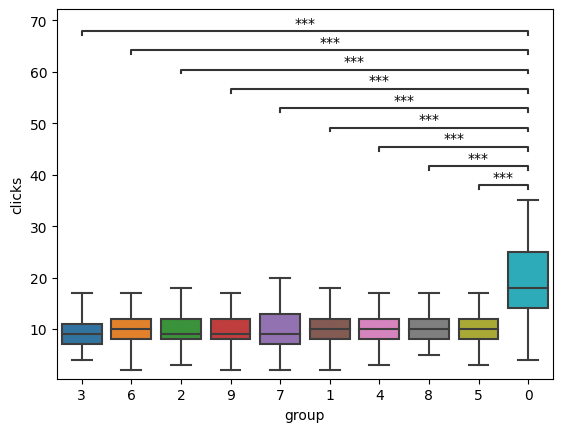

In [27]:
ax1 = Comparison_Plot2(df_main, "main", "group", "clicks")
plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 0: Custom statistical test, P_val:6.644e-03
7 vs. 1: Custom statistical test, P_val:5.472e-03
1 vs. 5: Custom statistical test, P_val:1.000e-03
9 vs. 1: Custom statistical test, P_val:2.359e-03
6 vs. 1: Custom statistical test, P_val:1.066e-02
3 vs. 1: Custom statistical test, P_val:2.920e-03
2 vs. 1: Custom statistical test, P_val:1.000e-03


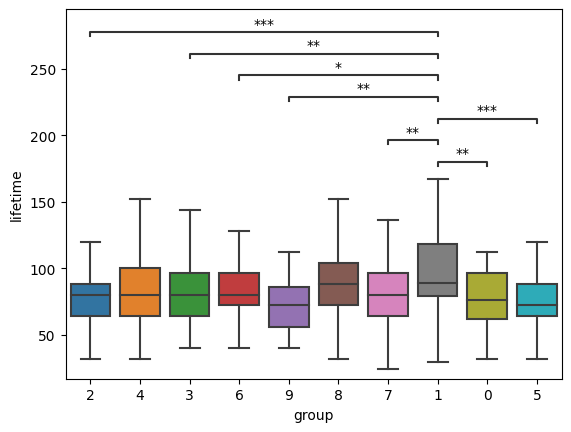

In [28]:
ax2 = Comparison_Plot2(df_login, "login", "group", "lifetime")
plt.show()

*** - show pairs with significant difference.

***

### With Segmentation

In [20]:
def Data_Prep2(dataframe, group, target, segment, segment_target):
    
    dataframe[group] = dataframe[group].apply(str)
    dataframe = dataframe.loc[dataframe[segment] == segment_target]
    
    def is_outlier(s):
        Q1 = s.quantile(0.25)
        Q3 = s.quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        return ~s.between(lower_limit, upper_limit)
    
    # Remove outliers
    dataframe = dataframe[~dataframe.groupby(group)[target].apply(is_outlier)]
    dataframe.reset_index(drop=True, inplace=True)
    
    return dataframe

In [21]:
Data_Prep2(df_main, "group", "clicks", "browser", "Chrome").head()

,id,group,clicks,lifetime,country,browser,date
0,1,3,8,42.00,China,Chrome,2019-08-25 15:01:46
1,3,2,9,36.00,India,Chrome,2019-02-21 18:22:14
2,5,9,7,27.00,India,Chrome,2019-12-14 13:12:22
3,6,7,7,24.00,France,Chrome,2019-02-10 01:05:37
4,7,1,15,51.48,United States,Chrome,2019-10-08 14:57:03


In [22]:
def Multivar_AB_Testing2(dataframe, page_name, group, target, segment, segment_target):
    
    dataframe = Data_Prep2(dataframe, group, target, segment, segment_target)
    
    # extract unique groups
    groups = []
    for g in dataframe[group].unique():
        df = dataframe[dataframe[group]==g]
        groups.append(df[target].values)
    
    # perform one-way ANONVA
    anova = stats.f_oneway(*groups)
    
    if anova[1] < 0.05: # if p<0.05, then at least one of the mean values is significantly different
        
        # perform Tukey's test
        tukey = pairwise_tukeyhsd(endog=dataframe[target],
                                  groups=dataframe[group],
                                  alpha=0.05)
        df_tukey = pd.DataFrame(data=tukey._results_table.data[1:], 
                                columns=tukey._results_table.data[0])
        
        # fetch the info about the groups and merge
        df_info = pd.read_csv("pages_info.csv", usecols=["page.version", "group.codes"])
        df_info = df_info[df_info['page.version'].str.contains(page_name.lower())]
        df_info['page.version.num'] = df_info['page.version'].str.split('.').str[1]
        df = df_tukey.merge(df_info, left_on="group1", right_on="page.version.num").merge(df_info, left_on="group2", right_on="page.version.num")
        df = df[["group1", "group.codes_x", "group2", "group.codes_y", "meandiff", "lower", "upper", "p-adj", "reject"]]
        df = df.rename({'group.codes_x': 'group1.codes', 'group.codes_y': 'group2.codes'}, axis=1)
        
    else:  # if p>0.05
        return "There is no significant difference across the means"

    return df

In [23]:
Multivar_AB_Testing2(df_main, "main", "group", "clicks", "browser", "Chrome").head()

,group1,group1.codes,group2,group2.codes,meandiff,lower,upper,p-adj,reject
0,0,original,1,title on left & login button is red,-8.1692,-10.7578,-5.5807,0.0000,True
1,0,original,2,title on right & login button is red,-7.8600,-10.5384,-5.1816,0.0000,True
2,1,title on left & login button is red,2,title on right & login button is red,0.3092,-1.5950,2.2135,1.0000,False
3,0,original,3,title on left & login button is orange,-8.6818,-11.2658,-6.0979,0.0000,True
4,1,title on left & login button is red,3,title on left & login button is orange,-0.5126,-2.2816,1.2564,0.9958,False


In [24]:
def Comparison_Plot3(dataframe, page_name, group, target, segment, segment_target):
    
    dataframe = Data_Prep2(dataframe, group, target, segment, segment_target)
    
    # perform Tukey's test
    tukey = pairwise_tukeyhsd(endog=dataframe[target],
                              groups=dataframe[group],
                              alpha=0.05)
    # return plot
    return tukey.plot_simultaneous()

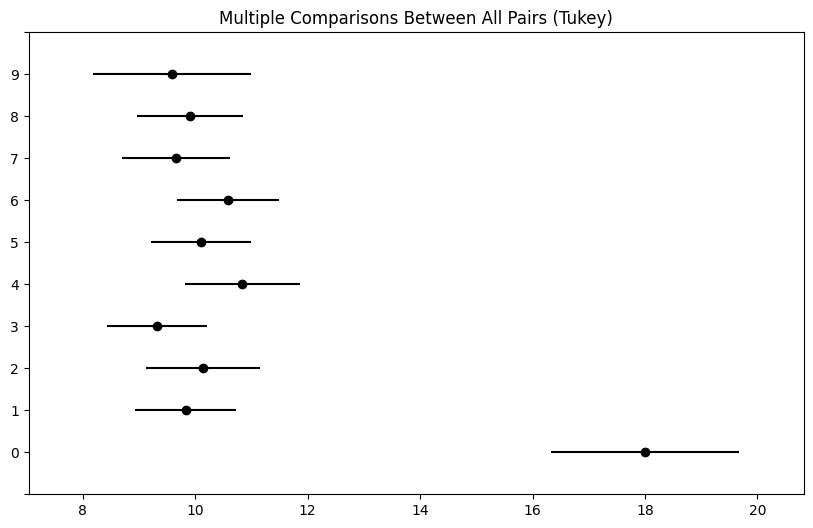

In [25]:
Comparison_Plot3(df_main, "main", "group", "clicks", "browser", "Chrome")